<a href="https://colab.research.google.com/github/torohitk/Simplilearn-DevOps/blob/master/SeedlingClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1 - Import Libraries, load datasets.....

In [3]:
# Step 1 - Import the libraries, load the dataset and print shape of data

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

images = np.load('/content/drive/My Drive/ColabNotebooks/ComputerVision/images.npy')
labels = pd.read_csv('/content/drive/My Drive/ColabNotebooks/ComputerVision/Labels.csv')
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


<IPython.core.display.Javascript object>

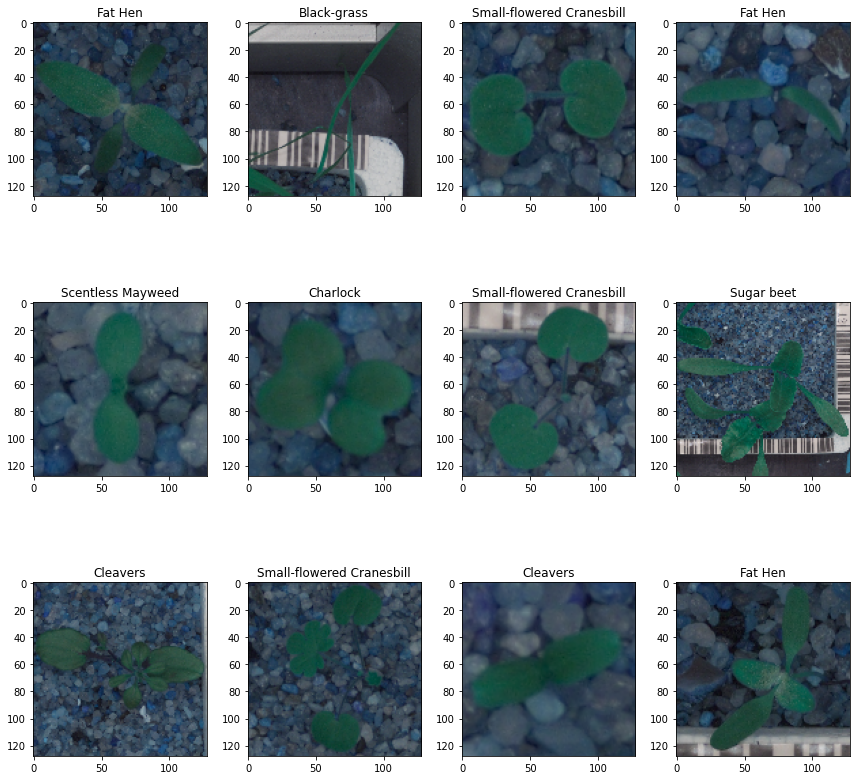

In [4]:
# Step 1 - Visualize images in the dataset
import random
#Set display window settings for the image visualization
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

#Display 12 random images from the images file and provide names from the Label.csv file
x = 12 
rows = x/4
cols = 4
axes=[]
fig = plt.figure(figsize=(12,12))

for i in range(0, x):
  rndnum = random.randint(0, 4750)
  img = images[rndnum]
  axes.append(fig.add_subplot(rows, cols, i+1))
  subplot_title = labels['Label'][rndnum]
  axes[-1].set_title(subplot_title)
  plt.imshow(img)  
fig.tight_layout()
plt.show()

# Step 2 - Data Pre-processing

Images Shape:  (4750, 128, 128, 3)


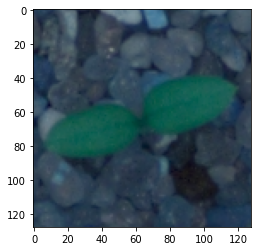

In [5]:
#Step 2 - Data Pre-processing - Normalization, Guassian Blurring, Visualize Data after pre-processing

#Read data from array and assign to X
from numpy import asarray
Images = asarray(images)
print('Images Shape: ', Images.shape)
plt.imshow(Images[2000])

#Normalization
Images = Images/255.0


X:  (4750, 128, 128, 3)


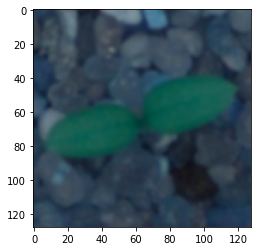

In [6]:
#Apply Gaussian Blurring
X = np.empty((4750, 128, 128, 3))

for idx, img in enumerate(X):
  X[idx]= cv2.GaussianBlur(Images[idx], (3,3),0)

#Visualize data after pre-processing
plt.imshow(X[2000])
print('X: ', X.shape)

# Step 3 - Make data compatible

In [7]:
#Step 3 - Make data compatible
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#Convert labels to one-hot-vectors
y = labels.values
enc = LabelBinarizer()
print('X shape: ', X.shape)
print('y shape:' , y.shape)

y = enc.fit_transform(y)

# Split data into test, train and validation to build the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=1)

#Check shape of data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_test shape:', X_test.shape)
print('X_Val shape:', X_val.shape)

X shape:  (4750, 128, 128, 3)
y shape: (4750, 1)
X_train shape: (3325, 128, 128, 3)
y_train shape: (3325, 12)
X_test shape: (712, 128, 128, 3)
y_test shape: (712, 12)
X_test shape: (712, 128, 128, 3)
X_Val shape: (713, 128, 128, 3)


Comment: Data appears to be compatible shape. The input to the Keras model requires the data to be in 128x128x3

Label:  7
Label Id: 7 
 Name: Scentless Mayweed


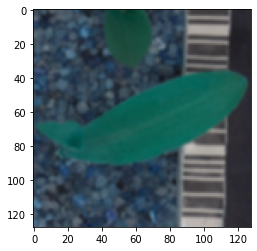

In [8]:
#Check label of y_train[0]
label_dict =  {0:'Small-flowered Cranesbill', 1:'Fat Hen', 2:'Shepherds Purse', 3: 'Common wheat', 4: 'Common Chickweed', 5: 'Charlock', 6: 'Cleavers', 7: 'Scentless Mayweed', 8: 'Sugar beet', 9: 'Maize', 10:'Black-grass', 11: 'Loose Silky-bent'}

TestImage = X_train[0]
TestLabel = (np.where((y_train[0]) ==1 ))[0][0]
print('Label: ', TestLabel)
print(f'Label Id: {TestLabel} \n Name: {label_dict[TestLabel]}')
plt.imshow(TestImage)

# Step 4 - Build the CNN

In [9]:
#Step 4 - Building CNN - Define Layers, Set Optimizer and loss function

#Import required Keras modules
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
                                                        # Dense: Just the regular densely-connected NN layer.
#Define Layers
#Initializing the CNN classifier - 3 sets of Conv. layers + Pooling layers
classifier = Sequential()
classifier.add(Conv2D(32, (5, 5), input_shape = (128, 128, 3), activation = 'relu', padding = 'same'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (5, 5), activation = 'relu', padding = 'same'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (5, 5), activation = 'relu', padding = 'valid'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#Flattening the layer before fully connected layers
classifier.add(Flatten())

#Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

#Adding dropout with probability 0.5
classifier.add(Dropout(0.5))

#Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))

#The final output layer with 12 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))   

#Set Optimizer and Loss Function
# initiate Adam optimizer
Opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
Loss = 'categorical_crossentropy'

#Compile the model
classifier.compile(optimizer = Opt, loss = Loss, metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

# Step 5 - Fit & Evaluate the model

In [10]:
#Step 5 - Fit, Evaluate Model and print confusion matrix

#Fit the model
history = classifier.fit(x=X_train, y = y_train, batch_size=32, epochs=30, validation_data=(X_val, Y_val))


Epoch 1/30
104/104 [==============================] - 2s 19ms/step - loss: 2.1224 - accuracy: 0.2818 - val_loss: 1.6115 - val_accuracy: 0.4600
Epoch 2/30
104/104 [==============================] - 1s 14ms/step - loss: 1.6463 - accuracy: 0.4220 - val_loss: 1.5032 - val_accuracy: 0.4558
Epoch 3/30
104/104 [==============================] - 1s 13ms/step - loss: 1.4473 - accuracy: 0.4914 - val_loss: 1.1925 - val_accuracy: 0.5750
Epoch 4/30
104/104 [==============================] - 1s 14ms/step - loss: 1.1535 - accuracy: 0.6048 - val_loss: 1.1152 - val_accuracy: 0.6017
Epoch 5/30
104/104 [==============================] - 1s 13ms/step - loss: 0.9713 - accuracy: 0.6683 - val_loss: 0.9356 - val_accuracy: 0.6788
Epoch 6/30
104/104 [==============================] - 1s 13ms/step - loss: 0.8158 - accuracy: 0.7164 - val_loss: 0.8934 - val_accuracy: 0.6844
Epoch 7/30
104/104 [==============================] - 1s 13ms/step - loss: 0.7754 - accuracy: 0.7299 - val_loss: 0.8219 - val_accuracy: 0.7111

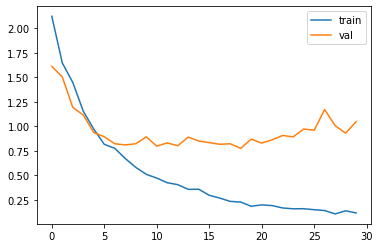

23/23 [==============================] - 0s 7ms/step - loss: 1.3969 - accuracy: 0.7514
Test loss: 1.3968627452850342
Test accuracy: 0.7514045238494873


In [11]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Evaluate trained model.
scores = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

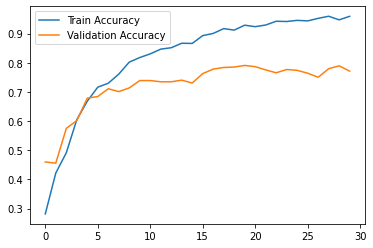

In [12]:
# plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [13]:
#use the model to predict the test data
print(X_test.shape)
Y_pred = classifier.predict(X_test)
print(Y_pred.shape)

(712, 128, 128, 3)
(712, 12)


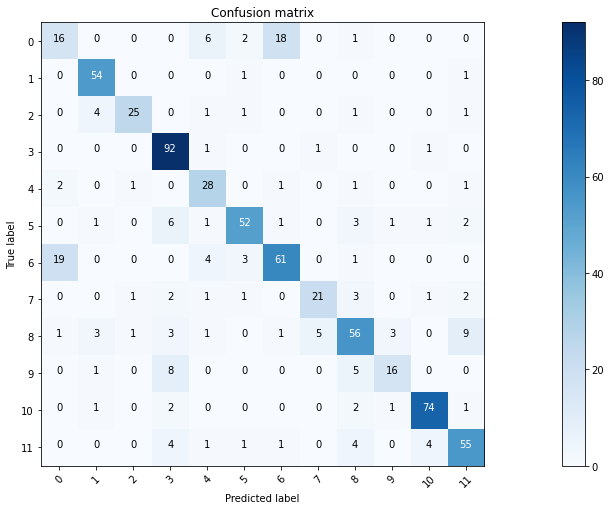

In [14]:
#Display Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools

plt.subplots(figsize=(22,7)) #set the size of the plot 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = classifier.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(12))

# Step 6 - Visualize Predictions

Actual Value: 3 
 Name: Common wheat
[0 0 0 1 0 0 0 0 0 0 0 0]
Predicted Value: 6 
 Name: Cleavers


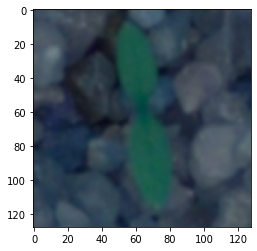

In [15]:
#Step 6 - Visualize predictions for  x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]
#Original Value
plt.imshow(X_test[2])
predlabel2 = (np.where((y_test[2]) ==1 ))[0][0]
print(f'Actual Value: {predlabel2} \n Name: {label_dict[predlabel2]}')
print(y_test[2])

#Predicted Value
y_pred = np.argmax(Y_pred[2], axis=0)
#print('Predicted Value for X_test[2]: ', y_pred)
print(f'Predicted Value: {y_pred} \n Name: {label_dict[y_pred]}')

Actual Value: 0 
 Name: Small-flowered Cranesbill
[1 0 0 0 0 0 0 0 0 0 0 0]
Predicted Value: 5 
 Name: Charlock


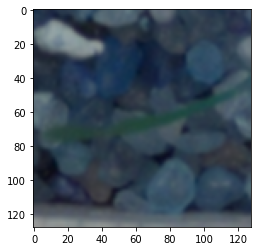

In [16]:
plt.imshow(X_test[3])
predlabel3 = (np.where((y_test[3]) ==1 ))[0][0]
print(f'Actual Value: {predlabel3} \n Name: {label_dict[predlabel3]}')
print(y_test[3])

#Predicted Value
y_pred = np.argmax(Y_pred[3], axis=0)
#print('Predicted Value for X_test[3]: ', y_pred)
print(f'Predicted Value: {y_pred} \n Name: {label_dict[y_pred]}')

Actual Value: 6 
 Name: Cleavers
[0 0 0 0 0 0 1 0 0 0 0 0]
Predicted Value: 10 
 Name: Black-grass


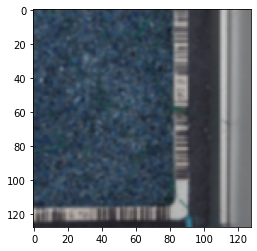

In [17]:
plt.imshow(X_test[33])
predlabel33 = (np.where((y_test[33]) ==1 ))[0][0]
print(f'Actual Value: {predlabel33} \n Name: {label_dict[predlabel33]}')
print(y_test[33])

#Predicted Value
y_pred = np.argmax(Y_pred[33], axis=0)
#print('Predicted Value for X_test[33]: ', y_pred)
print(f'Predicted Value: {y_pred} \n Name: {label_dict[y_pred]}')

Actual Value: 3 
 Name: Common wheat
[0 0 0 1 0 0 0 0 0 0 0 0]
Predicted Value: 6 
 Name: Cleavers


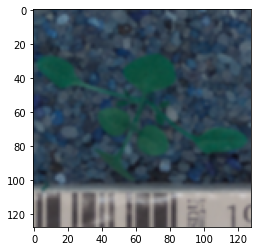

In [18]:
plt.imshow(X_test[36])
predlabel36 = (np.where((y_test[36]) ==1 ))[0][0]
print(f'Actual Value: {predlabel36} \n Name: {label_dict[predlabel36]}')
print(y_test[36])

#Predicted Value
y_pred = np.argmax(Y_pred[36], axis=0)
#print('Predicted Value for X_test[36]: ', y_pred)
print(f'Predicted Value: {y_pred} \n Name: {label_dict[y_pred]}')

Actual Value: 10 
 Name: Black-grass
[0 0 0 0 0 0 0 0 0 0 1 0]
Predicted Value: 1 
 Name: Fat Hen


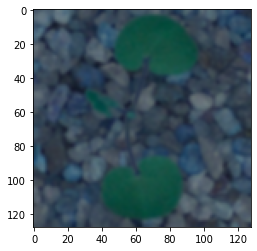

In [19]:
plt.imshow(X_test[59])
predlabel59 = (np.where((y_test[59]) ==1 ))[0][0]
print(f'Actual Value: {predlabel59} \n Name: {label_dict[predlabel59]}')
print(y_test[59])

#Predicted Value
y_pred = np.argmax(Y_pred[59], axis=0)
#print('Predicted Value for X_test[59]: ', y_pred)
print(f'Predicted Value: {y_pred} \n Name: {label_dict[y_pred]}')